# Cardio Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel,MNISTModel
from models.lr import LogisticRegression
from models.svm import LinearSVM
from models.rbf import RBFNet

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read and Process Data

In [2]:
df = pd.read_csv('data/mnist/train.csv')
# df = df_.drop(columns=['id'], axis=1).copy()

In [3]:
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [4]:
target_name = 'label'
target = df[target_name].replace({})

## Model Training

In [5]:
features = df.columns.drop('label').to_list()

df_X = df[features].copy()
df_y = df[target_name].copy()

In [6]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

# Assuming df_X is a Pandas DataFrame
mean = X_train.mean(axis=0)  # Mean for each feature
std = X_train.std(axis=0)    # Standard deviation for each feature

# Replace 0s in standard deviation with 1 to avoid division by zero
std_replaced = std.replace(0, 1)

X_train = (X_train - mean) / std_replaced
X_test = (X_test - mean) / std_replaced

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model
model = MNISTModel()
model._init_weights()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100  # Number of epochs. Adjust as necessary.
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.squeeze().long())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 2 == 0:  # Print every 2nd epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor.squeeze().long()).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Epoch [2/100], Loss: 2.4724
Epoch [4/100], Loss: 2.4020
Epoch [6/100], Loss: 2.3338
Epoch [8/100], Loss: 2.2678
Epoch [10/100], Loss: 2.2041
Epoch [12/100], Loss: 2.1426
Epoch [14/100], Loss: 2.0832
Epoch [16/100], Loss: 2.0258
Epoch [18/100], Loss: 1.9705
Epoch [20/100], Loss: 1.9170
Epoch [22/100], Loss: 1.8653
Epoch [24/100], Loss: 1.8154
Epoch [26/100], Loss: 1.7671
Epoch [28/100], Loss: 1.7204
Epoch [30/100], Loss: 1.6752
Epoch [32/100], Loss: 1.6315
Epoch [34/100], Loss: 1.5890
Epoch [36/100], Loss: 1.5479
Epoch [38/100], Loss: 1.5080
Epoch [40/100], Loss: 1.4693
Epoch [42/100], Loss: 1.4318
Epoch [44/100], Loss: 1.3954
Epoch [46/100], Loss: 1.3601
Epoch [48/100], Loss: 1.3257
Epoch [50/100], Loss: 1.2923
Epoch [52/100], Loss: 1.2599
Epoch [54/100], Loss: 1.2284
Epoch [56/100], Loss: 1.1978
Epoch [58/100], Loss: 1.1680
Epoch [60/100], Loss: 1.1391
Epoch [62/100], Loss: 1.1109
Epoch [64/100], Loss: 1.0835
Epoch [66/100], Loss: 1.0569
Epoch [68/100], Loss: 1.0309
Epoch [70/100], Lo

## Counterfactual Explanation

In [7]:
outputs

tensor([[-1.1005,  1.6452,  1.3518,  ..., -0.5868,  1.6814, -0.3221],
        [-1.3275,  4.0110, -0.2230,  ..., -0.7801, -0.1958, -0.1501],
        [-0.8671, -1.1311, -0.9037,  ...,  2.6238,  0.6924,  3.4038],
        ...,
        [ 1.9533,  0.3191,  3.0754,  ..., -0.0147,  0.2376, -1.5671],
        [ 3.7793, -0.8375, -0.4460,  ...,  0.0614, -1.1946, -0.3898],
        [-1.4676, -0.4161, -0.5637,  ..., -0.0885,  0.8997,  2.8810]])

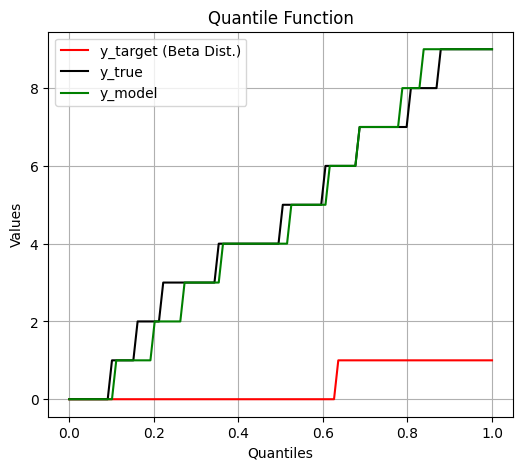

In [8]:
sample_num = 100
delta=0.15
alpha=0.1
N=10
explain_columns = features

indice = (X_test.sample(sample_num)).index

df_explain = X_test.loc[indice] # This is x in (3b) and (3c)

# X = X_test.loc[indice].values
y_prob = model(torch.FloatTensor(df_explain.values))
_, y = torch.max(y_prob, 1)

y_target = torch.round(torch.distributions.beta.Beta(0.2, 0.3).sample((sample_num,)))

y_true = y_test.loc[indice]

# Sort the arrays
y_target_sorted = np.sort(y_target.numpy())
y_true_sorted = np.sort(y_true)
y_sorted = np.sort(y.squeeze().detach().numpy())

# Generate quantiles
quantiles = np.linspace(0, 1, sample_num)

# Plotting
plt.figure(figsize=(6, 5))
plt.plot(quantiles, y_target_sorted, label='y_target (Beta Dist.)', color='red')
plt.plot(quantiles, y_true_sorted, label='y_true', color='black')
plt.plot(quantiles, y_sorted, label='y_model', color='green')


plt.title('Quantile Function')
plt.xlabel('Quantiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    df_X=df_explain, 
    explain_columns=explain_columns,
    y_target=y_target, 
    lr=1e-1, 
    n_proj=10, # This is 
    delta=delta)

DEBUG:root:test


In [11]:
y = y.float()

In [12]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

6.377340149051874

In [13]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=alpha, bootstrap=True)

(5.741445281139654, 7.829336910890564)

In [14]:
X_s = explainer.X[:, explainer.explain_indices].clone() 
X_t = explainer.X_prime[:, explainer.explain_indices].clone()

In [15]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

0.010494357322909025

In [16]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha, bootstrap=False)

(0.0, 0.0)

In [17]:
explainer.optimize(U_1=0.1, U_2=0.25, l=0, r=1, max_iter=100, tau=1e1, kappa=0.02, bootstrap=True)

INFO:root:Optimization started


RuntimeError: shape '[700, 1]' is invalid for input of size 7000

In [ ]:
# import os 
# import pickle 
# dump_data_path = './data/cardio/'
# with open(os.path.join(dump_data_path, "explainer_convergence.pkl"), "wb") as file:
#     pickle.dump(explainer, file)

In [ ]:
# import os 
# import pickle 
# dump_data_path = './data/cardio/'
# with open(os.path.join(dump_data_path, "explainer_convergence.pkl"), 'rb') as file:
#     explainer = pickle.load(file)

In [ ]:
s_qu = ""
s_u1 = ""

points_qu = list(map(lambda x: x.item(), explainer.swd_upper_list))
# points_list = list(map(lambda x: x.item(), explainer.swd_upper_list))[:iteration]
# points_list = list(map(lambda x: x.item() if type(x)==torch.Tensor else x, explainer.eta_list))
# points_list = explainer.interval_right_list

for i, v in enumerate(points_qu):
    s_qu += f"({i},{v})"
    s_u1 += f"({i},0.1)"
print("Qu, U1")
print(s_qu)
print(s_u1)

In [ ]:
s_qv = ""
s_u2 = ""

points_qv = list(map(lambda x: x.item(), explainer.wd_upper_list))

for i, v in enumerate(points_qv):
    s_qv += f"({i},{v})"
    s_u2 += f"({i},0.25)"
print("Qv, U2")
print(s_qv)
print(s_u2)

In [ ]:
s_eta = ""
s_eta_r = ""
s_eta_l = ""
eta_points = list(map(lambda x: x.item() if type(x)==torch.Tensor else x, explainer.eta_list))
eta_r_points = explainer.interval_left_list
eta_l_points = explainer.interval_right_list

for i, v in enumerate(eta_points):
    s_eta += f"({i},{v})"

for i, v in enumerate(eta_r_points):
    s_eta_r += f"({i},{v})"

for i, v in enumerate(eta_l_points):
    s_eta_l += f"({i},{v})"

print("eta, (l,r)")
print(s_eta)
print(s_eta_r)
print(s_eta_l)

In [ ]:
which_X = explainer.best_X

factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(
    which_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values,
    columns=df_X.columns,
)

dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == "int":
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

factual_y = pd.DataFrame(
    y.detach().numpy(), columns=[target_name], index=factual_X.index
)
counterfactual_y = pd.DataFrame(
    explainer.y.detach().numpy(), columns=[target_name], index=factual_X.index
)

# Recover the type of counterfactual_X
dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == "int":
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y
factual_X[target_name] = factual_y

In [ ]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

In [ ]:
import os
import pickle 

dump_data_path = './data/cardio/'

factual_X.to_csv(os.path.join(dump_data_path, "factual.csv"), index=False)
counterfactual_X.to_csv(
    os.path.join(dump_data_path, "counterfactual.csv"), index=False
)
with open(os.path.join(dump_data_path, "explainer.pkl"), "wb") as file:
    pickle.dump(explainer, file)

In [ ]:
import matplotlib.pyplot as plt

fontsize = 25

# Enable LaTeX text rendering in Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{times}",  # Ensure you use the times package
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman"],  # This should use Times font
    "font.size": fontsize
})

matrix_nu = explainer.wd.nu.detach().numpy()

mu_avg = torch.zeros_like(explainer.swd.mu_list[0])
for mu in explainer.swd.mu_list:
    mu_avg += mu

total_sum = mu_avg.sum()

matrix_mu = mu_avg / total_sum

# Determine the global minimum and maximum values across both matrices
vmin = min(matrix_mu.min(), matrix_nu.min())
vmax = max(matrix_mu.max(), matrix_nu.max())

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')  # Set figure background to white

# Set the background of each axis to white
for ax in axs:
    ax.set_facecolor('white')

# First subplot for matrix_mu with 'Blues' color map
im_mu = axs[0].imshow(matrix_mu, cmap='Blues', vmin=vmin, vmax=vmax)
axs[0].set_title("Heatmap of $\mu$")

# Second subplot for matrix_nu with 'Blues' color map
im_nu = axs[1].imshow(matrix_nu, cmap='Blues', vmin=vmin, vmax=vmax)
axs[1].set_title("Heatmap of $\\nu$")

# Create a colorbar for the whole figure
fig.colorbar(im_mu, ax=axs, orientation='vertical')

plt.savefig('pictures/transportation_plan.eps', format='eps', bbox_inches='tight')


# # Display the plots
plt.show()
plt.close(fig)

In [ ]:
row_num  = 20

# Interleave rows
combined = pd.concat([factual_X.head(row_num), counterfactual_X.head(row_num)]).sort_index(kind='merge')

# Define formatters for specific columns
formatters = {
    "cardio": lambda x: f"{x:.4f}",
    "weight": lambda x: f"{x:.1f}"
}


# Convert to LaTeX
latex_code = combined.to_latex(index=False, formatters=formatters, 
                               caption="[\\textit{{German-Credit}}] Data points of factual and counterfactual distributions.", label="tab:german-credit")

print(latex_code)